In [31]:
import json
import os
import re
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import logging
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

# Helper Function

In [32]:
def preprocess_amazon_data(df, max_samples=10000):
    logging.info("Starting data preprocessing")
    
    try:
        # Data Cleaning
        df_filtered = df[['text', 'title', 'rating', 'timestamp', 'helpful_vote']].copy()
        
        # Combine title and text
        df_filtered['combined_text'] = df_filtered.apply(
            lambda x: f"{x['title']} {x['text']}", axis=1
        )
        
        # Text normalization : removing urls, punctuations, whitespaces
        def normalize_text(text):
            text = text.lower()
            text = re.sub(r'http\S+|www\S+|https\S+', '', text)
            text = re.sub(r'[^\w\s]', '', text)
            text = re.sub(r'\s+', ' ', text)
            return text.strip()
        
        df_filtered['normalized_text'] = df_filtered['combined_text'].apply(normalize_text)
        
        # Sentiment Classification
        df_filtered['sentiment'] = df_filtered['rating'].apply(
            lambda x: 1 if x >= 4 else (0 if x <= 2 else 2)
        )
        
        # Remove neutral reviews
        df_filtered = df_filtered[df_filtered['sentiment'] != 2]
        
        # Balance Dataset
        min_samples = min(min(df_filtered['sentiment'].value_counts()), max_samples // 2)
        df_balanced = pd.concat([
            df_filtered[df_filtered['sentiment'] == label].sample(min_samples)
            for label in [0, 1]
        ])
        
        logging.info(f"Preprocessing completed. Final dataset shape: {df_balanced.shape}")
        return df_balanced
        
    except Exception as e:
        logging.error(f"Error in preprocessing: {str(e)}")
        raise

# Helper Class

In [103]:
class Gpt2ClassificationCollator(object):
    """
    Data Collator used for GPT2 in a classificaiton rask.
    """
    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        # tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        """
        Load Text and Inputs
        """
        # get all text and label.
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        # encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # use tokenizer get input
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,
                                    max_length=self.max_sequence_len)
        inputs.update({'labels': torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
    """
    Train pytorch model on a single pass through the data loader.
    """
    global model
    predictions_label = []
    true_label = []
    
    total_loss = 0

    # Set as train mode.
    model.train()
    
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_label += batch['labels'].numpy().flatten().tolist()

        # move batch to device
        batch = {k: v.type(torch.long).to(device_) for k, v in batch.items()}
        model.zero_grad()
        outputs = model(**batch)

        # get logits and loss 
        loss, logits = outputs[:2]
        
        # update Loss 
        total_loss += loss.item()
        
        # Backward propagation for gradients
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # optimize 
        optimizer_.step()
        # update the learning rate.
        scheduler_.step()
        # get logits and final label
        logits = logits.detach().cpu().numpy()
        predictions_label += logits.argmax(axis=-1).flatten().tolist()
            
                
    # get avg loss
    avg_epoch_loss = total_loss / len(dataloader)

    return true_label, predictions_label, avg_epoch_loss



class TextDataset(Dataset):
    def __init__(self, df, use_tokenizer=None):
        """
        df: pandas DataFrame with 'text' and 'label' columns.
        """
        self.texts = df['text'].tolist()
        self.labels = df['rating'].tolist()
        self.n_examples = len(self.labels)
        self.use_tokenizer = use_tokenizer

    def __len__(self):
        return self.n_examples

    def __getitem__(self, item):
       
        text = self.texts[item]
        label = self.labels[item]
        
        if self.use_tokenizer:
            text = self.use_tokenizer(text)

        return {'text': text, 'label': label}

def validation(dataloader, device_):

    global model
    # save labels
    predictions_labels = []
    true_labels = []
    # total loss for this epoch.
    total_loss = 0

    # evalute
    model.eval()
    for batch in tqdm(dataloader, total=len(dataloader)):
         
        # add original labels
        true_labels += batch['labels'].numpy().flatten().tolist()
        # move batch to device
        batch = {k: v.type(torch.long).to(device_) for k, v in batch.items()}
         
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            # update loss
            total_loss += loss.item()

            # get predicitons to list
            predict_content = logits.argmax(axis=-1).flatten().tolist()

            # update list
            predictions_labels += predict_content

    # get avg loss
    avg_epoch_loss = total_loss / len(dataloader)

    return true_labels, predictions_labels, avg_epoch_loss

# Training setting

In [104]:
set_seed(0)
# for model
epochs = 3
batch_size = 32
max_length = 128
# use gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# the model we want to use.
model_name_or_path = 'gpt2'

In [105]:
data = []
file = 'All_Beauty.jsonl'
with open(file, 'r') as fp:
    for line in fp:
        if line.strip():  # avoid empty lines
            record = json.loads(line)
            data.append(record)

df = pd.DataFrame(data)

In [106]:
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [107]:
df_balanced = preprocess_amazon_data(df)

In [108]:
df_balanced = df_balanced[['normalized_text','sentiment']].rename(columns={
    'normalized_text': 'text',
    'sentiment': 'rating'})
df_balanced.head()

,text,rating
121671,not much difference i wont say they didnt work...,0
256727,sized small it claims to be an xl cap but its ...,0
58231,two stars this product did not really work for...,0
203586,unsure not sure it works pretty expensive,0
108834,hair mascara smears on others and irritates eyes,0


In [109]:
train_df, test_df = train_test_split(df_balanced, test_size=0.2, random_state=42)

In [110]:
# labels 
labels_ids = { 1: 1, 0: 0}
n_labels=2
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# get model tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# padding setting
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

Loading configuraiton...
Loading tokenizer...


In [111]:
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding as len of tokenize
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id 
model.config.pad_token_id = model.config.eos_token_id

model.to(device)

Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [113]:
print('Dealing with Train...')
# create train set
train_dataset = TextDataset(train_df)
print('Created `train_dataset` with %d examples!'%len(train_dataset))
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,
                                                          labels_encoder=labels_ids,
                                                          max_sequence_len=max_length)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print('Dealing with Validation...')
# create test set
valid_dataset =  TextDataset(test_df)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))
# Out optimizer
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # default is 5e-5
                  eps = 1e-8 # default is 1e-8.
                  )

total_steps = len(train_dataloader) * epochs

# create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}

all_acc = {'train_acc':[], 'val_acc':[]}


print('Epoch')
for epoch in tqdm(range(epochs)):
    print()
    print('Training on batches...')
    # Perform one full pass over the training set.
    train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)

    print('Validation on batches...')
    valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
    val_acc = accuracy_score(valid_labels, valid_predict)

    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))

    # get loss value for plotting the learning curve
    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

Dealing with Train...
Created `train_dataset` with 8000 examples!
Created `train_dataloader` with 250 batches!
Dealing with Validation...
Created `valid_dataset` with 2000 examples!
Created `eval_dataloader` with 63 batches!
Epoch


G:\Anaconda3\envs\pytorch\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/250 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/63 [00:00<?, ?it/s]

  train_loss: 0.14224 - val_loss: 0.17823 - train_acc: 0.94988 - valid_acc: 0.94150

Training on batches...


  0%|          | 0/250 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/63 [00:00<?, ?it/s]

  train_loss: 0.09596 - val_loss: 0.19349 - train_acc: 0.96475 - valid_acc: 0.94450

Training on batches...


  0%|          | 0/250 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/63 [00:00<?, ?it/s]

  train_loss: 0.06550 - val_loss: 0.20502 - train_acc: 0.97862 - valid_acc: 0.94600


In [114]:
model.save_pretrained("GPT2_2labes_10000")
tokenizer.save_pretrained("GPT2_2labes_10000")

('GPT2_2labes_10000\\tokenizer_config.json',
 'GPT2_2labes_10000\\special_tokens_map.json',
 'GPT2_2labes_10000\\vocab.json',
 'GPT2_2labes_10000\\merges.txt',
 'GPT2_2labes_10000\\added_tokens.json')

In [116]:
data = {**all_loss, **all_acc}
df = pd.DataFrame(data)

# Plot Loss

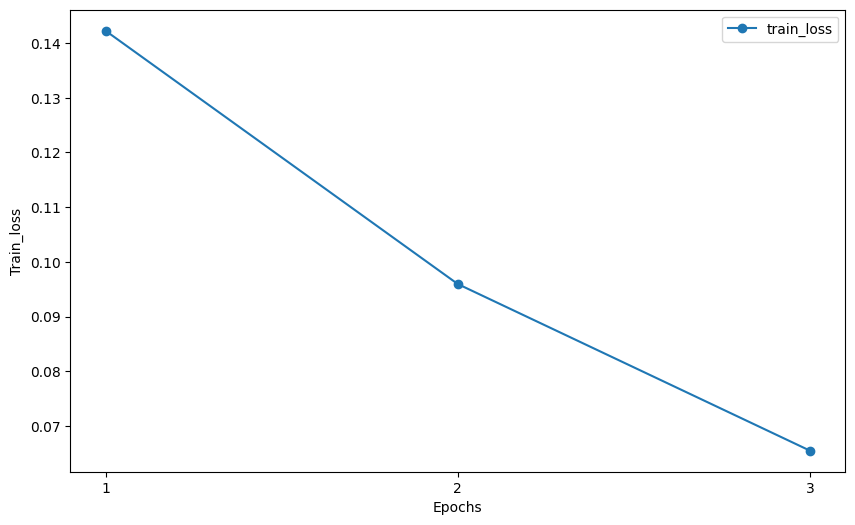

In [117]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df.index+1, df['train_loss'], label='train_loss', marker='o')
plt.xticks(ticks=(df.index + 1))
plt.xlabel('Epochs')
plt.ylabel('Train_loss')
plt.legend()
plt.show()

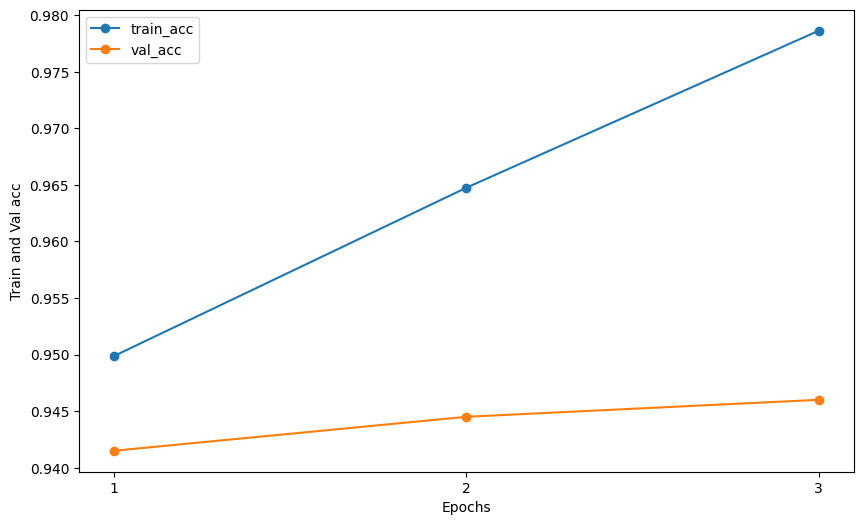

In [118]:
plt.figure(figsize=(10, 6))
plt.plot(df.index+1, df['train_acc'], label='train_acc', marker='o')
plt.plot(df.index+1, df['val_acc'], label='val_acc', marker='o')
plt.xticks(ticks=(df.index + 1))
plt.xlabel('Epochs')
plt.ylabel('Train and Val acc')
plt.legend()
plt.show()

# classification report

In [119]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report

inputs = tokenizer(
    test_df['text'].tolist(),
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=max_length
)
dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
batch_size = 16  
dataloader = DataLoader(dataset, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
all_predictions = []

with torch.no_grad():
    for batch in dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)

        batch_inputs = {
            'input_ids': batch_input_ids,
            'attention_mask': batch_attention_mask
        }

        outputs = model(**batch_inputs)
        logits = outputs.logits

        # get prediction
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()

        # append prediction
        all_predictions.extend(predictions)

all_predictions = torch.tensor(all_predictions).numpy()

In [122]:

report = classification_report(
    test_df['rating'],
    predicted_labels,
)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1012
           1       0.94      0.96      0.95       988

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



In [124]:
from torchinfo import summary
print("Model Summary:")
summary(model, input_size=(1, model.config.n_positions), dtypes=[torch.long])

Model Summary:


Layer (type:depth-idx)                             Output Shape              Param #
GPT2ForSequenceClassification                      [1, 12, 1024, 64]         --
├─GPT2Model: 1-1                                   [1, 12, 1024, 64]         --
│    └─Embedding: 2-1                              [1, 1024, 768]            38,597,376
│    └─Embedding: 2-2                              [1, 1024, 768]            786,432
│    └─Dropout: 2-3                                [1, 1024, 768]            --
│    └─ModuleList: 2-4                             --                        --
│    │    └─GPT2Block: 3-1                         [1, 1024, 768]            7,087,872
│    │    └─GPT2Block: 3-2                         [1, 1024, 768]            7,087,872
│    │    └─GPT2Block: 3-3                         [1, 1024, 768]            7,087,872
│    │    └─GPT2Block: 3-4                         [1, 1024, 768]            7,087,872
│    │    └─GPT2Block: 3-5                         [1, 1024, 768]         